# Predicting octane numbers from NIR spectra

In this example, we will predict [octane numbers](https://en.wikipedia.org/wiki/Octane_rating) from measured NIR spectra. Specifically, we will compare a least squares model to a partial least squares model and we will
use cross-validation to check the performance of the models.

## Reading the raw data

The raw data can be found in the file [gasoline.csv](./gasoline.csv). We will here load it with pandas and
extract the octane number, the spectra, and the wavelengths for the spectra.

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="ticks", context="notebook", palette="muted")
%matplotlib inline

np.random.seed(2022)  # Set random state to get the same results for each run

In [34]:
# Load the data set:
data = pd.read_csv("gasoline.csv")
# Each row contain a measured spectrum and a corresponding octane number:
# - extract the octane numbers:
yvars = ["octane"]
octane = data[yvars].to_numpy()
# - extract the spectra:
xvars = [i for i in data.columns if i not in yvars]
spectra = data[xvars].to_numpy()
# - get the wavelengths:
wavelengths = np.array([int(i.split()[0].split(".")[1]) for i in xvars])
print(f"Number of wavelengths measured: {len(xvars)}")
data.describe()


Number of wavelengths measured: 401


,octane,NIR.900 nm,NIR.902 nm,NIR.904 nm,NIR.906 nm,NIR.908 nm,NIR.910 nm,NIR.912 nm,NIR.914 nm,NIR.916 nm,...,NIR.1682 nm,NIR.1684 nm,NIR.1686 nm,NIR.1688 nm,NIR.1690 nm,NIR.1692 nm,NIR.1694 nm,NIR.1696 nm,NIR.1698 nm,NIR.1700 nm
1,85.30,-0.050193,-0.045903,-0.042187,-0.037177,-0.033348,-0.031207,-0.030036,-0.031298,-0.034217,...,1.198461,1.224243,1.242645,1.250789,1.246626,1.250985,1.264189,1.244678,1.245913,1.221135
2,85.25,-0.044227,-0.039602,-0.035673,-0.030911,-0.026675,-0.023871,-0.022571,-0.025410,-0.028960,...,1.128877,1.148342,1.189116,1.223242,1.253306,1.282889,1.215065,1.225211,1.227985,1.198851
3,88.45,-0.046867,-0.041260,-0.036979,-0.031458,-0.026520,-0.023346,-0.021392,-0.024993,-0.029309,...,1.147964,1.167798,1.198287,1.237383,1.260979,1.276677,1.218871,1.223132,1.230321,1.208742
4,83.40,-0.046705,-0.042240,-0.038561,-0.034513,-0.030206,-0.027680,-0.026042,-0.028280,-0.030920,...,1.160089,1.169350,1.201066,1.233299,1.262966,1.272709,1.211068,1.215044,1.232655,1.206696
5,87.90,-0.050859,-0.045145,-0.041025,-0.036357,-0.032747,-0.031498,-0.031415,-0.034611,-0.037781,...,1.252712,1.238013,1.259616,1.273713,1.296524,1.299507,1.226448,1.230718,1.232864,1.202926


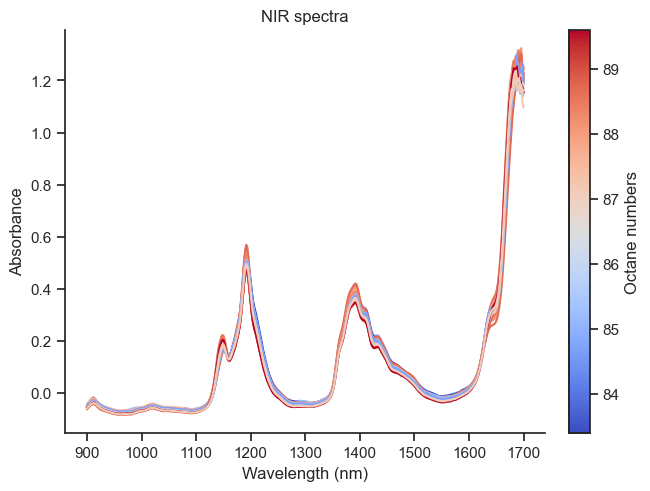

In [10]:
# Let us visualize the spectra, just to see what we have to work with:
# We add some color, so we can color the spectra according to
# the octane numbers:
norm = mpl.colors.Normalize(vmin=octane.min(), vmax=octane.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm")

fig, axi = plt.subplots(constrained_layout=True)
axi.set_title("NIR spectra")
for i, speci in enumerate(spectra):
    axi.plot(wavelengths, speci, color=cmap.to_rgba(octane[i]))
axi.set(xlabel="Wavelength (nm)", ylabel="Absorbance")
# axi.set_facecolor("0.975")
fig.colorbar(cmap, ax=axi, label="Octane numbers")
sns.despine(fig=fig)

From the figure above, we see that there is some difference in the spectra, depending on the octane number. So, let us see if we can use this to create some models for predicting the octane numbers.

## Least squares and PLS with test-train and cross-validation

In [13]:
from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler

# Create training and test sets:
X_train, X_test, Y_train, Y_test = train_test_split(spectra, octane, test_size=0.3)

scaler_x = StandardScaler().fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler().fit(Y_train)
Y_train = scaler_y.transform(Y_train)
Y_test = scaler_y.transform(Y_test)

In [36]:
# Create a PLS model, but use cross-validation to find
# the best number of pls components to use:
from sklearn.cross_decomposition import PLSRegression

parameters = {
    "n_components": range(1, 11),
}

grid = GridSearchCV(
    PLSRegression(),
    parameters,
    # scoring='r2',
    scoring="neg_mean_squared_error",
    refit=True,
)

grid.fit(X_train, Y_train)
print(grid.best_params_)
pls_model_optimized = grid.best_estimator_
B_PLS = pls_model_optimized.coef_[0, :]


{'n_components': 5}


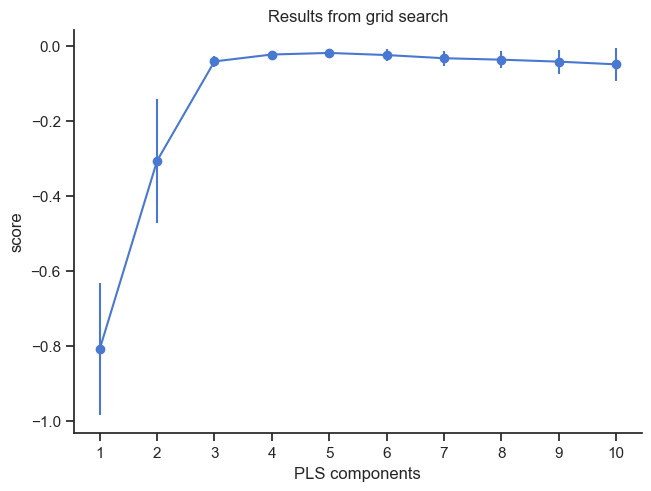

In [21]:
fig, axi = plt.subplots(constrained_layout=True)
score = grid.cv_results_["mean_test_score"]
score_std = grid.cv_results_["std_test_score"]
axi.errorbar(
    parameters["n_components"],
    score,
    yerr=score_std,
    marker="o",
)
axi.set_xticks(parameters["n_components"])
axi.set(
    xlabel="PLS components", ylabel="score", title="Results from grid search"
)
sns.despine(fig=fig)

In [27]:
# Create a least squares model and train it:
from sklearn.linear_model import LinearRegression

leastsquares = LinearRegression(fit_intercept=False)
leastsquares.fit(X_train, Y_train)
B_MLR = leastsquares.coef_[0, :]


In [28]:
# Create a LASSO model and train it:
from sklearn.linear_model import Lasso

parameters_lasso = {"alpha": np.logspace(-3, 2, 10)}

grid_lasso = GridSearchCV(
    Lasso(fit_intercept=False, max_iter=10000),
    parameters_lasso,
    scoring="neg_mean_squared_error",
    refit=True,
)
grid_lasso.fit(X_train, Y_train)
print(grid_lasso.best_params_)
lasso_model_optimized = grid_lasso.best_estimator_
B_lasso = lasso_model_optimized.coef_

{'alpha': 0.01291549665014884}


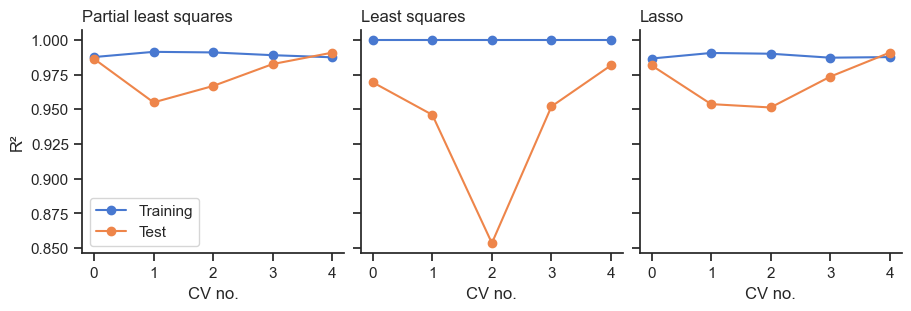

In [29]:
# Check performance with cross-validation:
fig, axes = plt.subplots(
    constrained_layout=True, ncols=3, sharex=True, sharey=True, figsize=(9, 3)
)

axes[0].set_title("Partial least squares", loc="left")
axes[1].set_title("Least squares", loc="left")
axes[2].set_title("Lasso", loc="left")

models = [pls_model_optimized, leastsquares, lasso_model_optimized]

for i, model in enumerate(models):
    cv_results = cross_validate(
        model,
        X_train,
        Y_train,
        scoring=("r2", "neg_mean_squared_error"),
        return_train_score=True,
    )
    axes[i].plot(cv_results["train_r2"], label="Training", marker="o")
    axes[i].plot(cv_results["test_r2"], label="Test", marker="o")
    axes[i].set_xlabel("CV no.")
axes[0].set_ylabel("R²")
axes[0].legend()
sns.despine(fig=fig)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score


def get_scores(y, y_hat):
    r2 = r2_score(y, y_hat)
    rmse = mean_squared_error(y, y_hat, squared=False)
    return r2, rmse


def add_scores(model, X_train, y_train, X_test, y_test, ax):
    """Plot y vs y_hat for test and training."""
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    r2_train, rmsec = get_scores(y_train, y_hat_train)
    r2_test, rmsep = get_scores(y_test, y_hat_test)

    txt_train = f"R²(train) = {r2_train:.2f}\nRMSEC = {rmsec:.2f}"
    txt_test = f"R²(test) = {r2_test:.2f}\nRMSEP = {rmsep:.2f}"

    ax.scatter(Y_train, y_hat_train, label=txt_train)
    ax.scatter(Y_test, y_hat_test, label=txt_test)
    ax.legend(fontsize="small")

c:\Coding\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Coding\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Coding\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Coding\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error

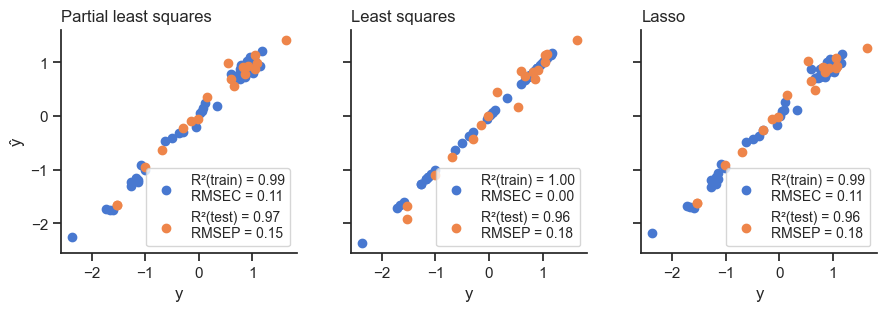

In [31]:
fig, axes = plt.subplots(
    constrained_layout=True,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(9, 3),
)

axes[0].set_title("Partial least squares", loc="left")
axes[1].set_title("Least squares", loc="left")
axes[2].set_title("Lasso", loc="left")

models = [pls_model_optimized, leastsquares, lasso_model_optimized]

for i, model in enumerate(models):
    axes[i].set_aspect("equal")
    add_scores(model, X_train, Y_train, X_test, Y_test, axes[i])
    axes[i].set_xlabel("y")
axes[0].set_ylabel("ŷ")
sns.despine(fig=fig)

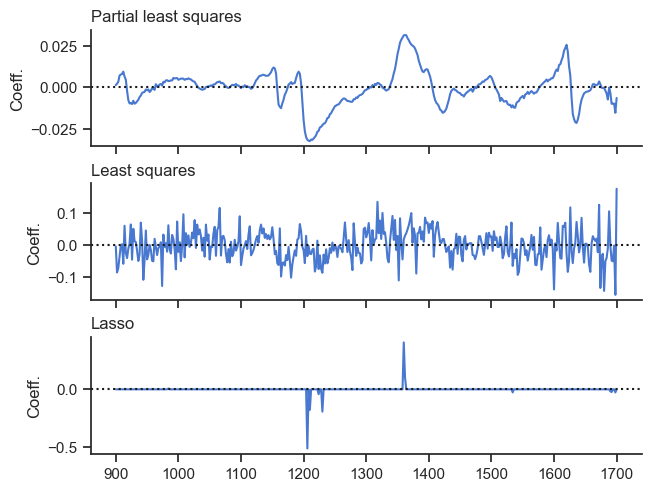

In [32]:
fig, axes = plt.subplots(
    constrained_layout=True,
    ncols=1,
    nrows=3,
    sharex=True,
)

axes[0].set_title("Partial least squares", loc="left")
axes[1].set_title("Least squares", loc="left")
axes[2].set_title("Lasso", loc="left")

coeffs = [B_PLS, B_MLR, B_lasso]

for i, coef in enumerate(coeffs):
    axes[i].plot(wavelengths, coef)
    axes[i].axhline(y=0.0, ls=":", color="k")
    axes[i].set_ylabel("Coeff.")
sns.despine(fig=fig)

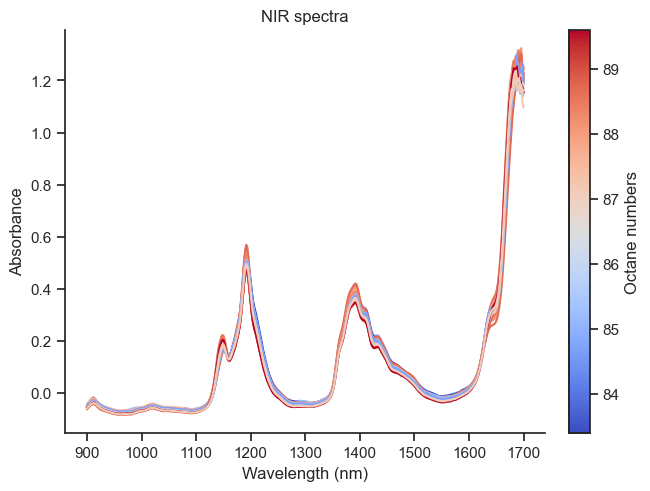

In [33]:
norm = mpl.colors.Normalize(vmin=octane.min(), vmax=octane.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm")
fig, axi = plt.subplots(constrained_layout=True)
axi.set_title("NIR spectra")
for i, speci in enumerate(spectra):
    axi.plot(wavelengths, speci, color=cmap.to_rgba(octane[i]))

# axi.plot(wavelengths, B_lasso)
axi.set(xlabel="Wavelength (nm)", ylabel="Absorbance")
# axi.set_facecolor("0.975")
fig.colorbar(cmap, ax=axi, label="Octane numbers")
sns.despine(fig=fig)